## Etapa 1: Importação das bibliotecas


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
dropout = 0.5
epochs = 50
batch_size = 128
learning_rate=0.001
k = 5

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import plot_confusion_matrix ,roc_auc_score, roc_curve,auc
from sklearn.metrics import classification_report
import itertools
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import itertools
from scipy import interp
from itertools import cycle


In [4]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [5]:
def L1(m, l1_lambda):
    l1_lambda = 0.001
    l1_norm = sum(p.abs().sum()
        for p in model.parameters())
 
    return l1_lambda * l1_norm

def L2(m, l2_lambda):
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
        for p in model.parameters())
 
    return l2_lambda * l2_norm

In [6]:
class Fold:
    def __init__(self):
        self.train_loss      = []
        self.train_accuracy  = [] 
        self.test_loss       = []
        
        self.test_accuracy   = []
        self.test_precision  = []
        self.test_recall     = []
        self.test_f1_score   = []
        self.test_specificity= []

        self.major_accuracy  = 0
        
        # Não utilizados no treinamento e teste
        self.last_pred       = np.array([], dtype=int) 
        self.last_true       = np.array([], dtype=int) 
        self.last_score      = np.array([], dtype=float) 

        
        self.accuracy    = 0.
        self.precision   = 0.
        self.recall      = 0.
        self.specificity = 0.
        self.f1          = 0.
       
        self.confusion_matrix=[]


In [7]:
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super(DenseNeuralNetwork, self).__init__()
        
        self.dense1 = nn.Sequential(
            nn.Linear(n_previsores, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.dense2 = nn.Sequential(
            nn.Linear(n_hiden, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
          
        self.dense3 = nn.Linear(n_hiden, n_classes)

    def forward(self, X):
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
    

        return X

In [8]:
class Cnn1dNeuralNetwork(nn.Module):
    def __init__(self):
        super(Cnn1dNeuralNetwork, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, out_channels = 16,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(16,32 , kernel_size=3, stride=1, padding=1),            
            nn.BatchNorm1d(32),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
     
        
        
        self.flatten1 = nn.Flatten()

        self.dense1 = nn.Sequential( 
            nn.Linear(320, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )   
        
        
        self.dense2 = nn.Sequential( 
            nn.Linear(230, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )  
       
        self.dense3 = nn.Linear(230, n_classes)            

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten1(X)
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        return X

In [9]:
base = pd.read_csv('datasets/output_full.csv',sep=';',usecols = 
                   
    [
    'forward_pl_mean','forward_piat_mean','forward_pps_mean','forward_bps_mean',
    'forward_pl_var','forward_piat_var','forward_pps_var','forward_bps_var',
    'forward_pl_q1','forward_pl_q3','forward_piat_q1','forward_piat_q3',
    'forward_pl_max','forward_pl_min','forward_piat_max','forward_piat_min',
    'forward_pps_max','forward_pps_min','forward_bps_max','forward_bps_min',
    'reverse_pl_mean','reverse_piat_mean','reverse_pps_mean','reverse_bps_mean',
    'reverse_pl_var','reverse_piat_var','reverse_pps_var','reverse_bps_var',
    'reverse_pl_q1','reverse_pl_q3','reverse_piat_q1','reverse_piat_q3',
    'reverse_pl_max','reverse_pl_min','reverse_piat_max','reverse_piat_min',
    'reverse_pps_max','reverse_pps_min','reverse_bps_max','reverse_bps_min',
    'category'
   ])

base = base[base.category.isin([
    'CHAT-ICQ',
    'CHAT-GMAIL',
    'CHAT-FACEBOOK',
    'CHAT-HANGOUTS',
    
    'FILE-SFTP-DOWN',
    'FILE-SKYPE',
    'FILE-FTPS',
    
    'STR-SPOTIFY',
    'STR-VIMEO',
    'STR-YOUTUBE',
    'STR-NETFLIX', 
    
    'VIDEO-SKYPE',
    'VIDEO-HANGOUTS',
    
    'AUDIO-VOIPBUSTER',
    'AUDIO-SKYPE',
    'AUDIO-HANGOUTS',
    'AUDIO-FACEBOOK',
    'EMAIL',
    
])]

In [10]:
base.shape

(5976, 41)

In [11]:
base = shuffle(base)
base.head()

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min,category
2320,287.772375,0.830825,2.573733,701.635233,9994.544569,1.243381,5.924545,2.631746e+05,263.240196,355.750000,...,0.547514,873.166667,79.500000,5.029500,0.097833,10.221465,0.198827,8925.042589,79.331942,CHAT-FACEBOOK
4757,650.428571,0.120524,8.297116,5396.681154,0.000000,0.000000,0.000000,0.000000e+00,650.428571,650.428571,...,0.070971,83.742857,83.742857,0.070971,0.070971,14.090177,14.090177,1179.951691,1179.951691,EMAIL
3789,138.334931,0.025967,48.773281,6814.973382,172.820264,0.001195,71.158756,1.679454e+06,132.606719,144.053571,...,0.020012,159.458661,64.500000,0.289000,0.018906,52.892235,3.460208,8307.050645,223.183391,AUDIO-SKYPE
828,134.163508,1.695137,4.537255,721.127172,42065.841847,6.415728,154.673872,5.022461e+06,0.000000,170.625000,...,0.884667,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420,STR-SPOTIFY
5848,108.653414,0.325038,3.215327,352.853136,16.422496,0.001220,1.813721,3.252936e+04,107.800000,108.000000,...,0.030708,381.907692,129.230769,0.067846,0.029014,34.465683,14.739229,12314.713761,1904.761905,AUDIO-FACEBOOK


In [12]:
# Separando previsores e classes
base_columns= len(base.columns)-1
previsores = base.iloc[ :, :base_columns]
classe = base.iloc[ :, base_columns]

In [13]:
previsores

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q1,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min
2320,287.772375,0.830825,2.573733,701.635233,9994.544569,1.243381,5.924545,2.631746e+05,263.240196,355.750000,...,0.285830,0.547514,873.166667,79.500000,5.029500,0.097833,10.221465,0.198827,8925.042589,79.331942
4757,650.428571,0.120524,8.297116,5396.681154,0.000000,0.000000,0.000000,0.000000e+00,650.428571,650.428571,...,0.070971,0.070971,83.742857,83.742857,0.070971,0.070971,14.090177,14.090177,1179.951691,1179.951691
3789,138.334931,0.025967,48.773281,6814.973382,172.820264,0.001195,71.158756,1.679454e+06,132.606719,144.053571,...,0.019860,0.020012,159.458661,64.500000,0.289000,0.018906,52.892235,3.460208,8307.050645,223.183391
828,134.163508,1.695137,4.537255,721.127172,42065.841847,6.415728,154.673872,5.022461e+06,0.000000,170.625000,...,0.000000,0.884667,1480.612022,66.000000,10.105000,0.012977,77.060046,0.098961,111404.293204,6.531420
5848,108.653414,0.325038,3.215327,352.853136,16.422496,0.001220,1.813721,3.252936e+04,107.800000,108.000000,...,0.030491,0.030708,381.907692,129.230769,0.067846,0.029014,34.465683,14.739229,12314.713761,1904.761905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,91.817272,0.737894,1.873036,173.891362,307.491126,0.191827,1.048145,1.054148e+04,83.130435,88.000000,...,0.288171,0.505850,266.791667,77.800000,1.009700,0.188000,5.319149,0.990393,1272.962227,77.052590
2490,182.566667,2.822017,0.519562,129.853405,20532.021905,3.100070,0.088735,1.736254e+04,60.000000,323.150000,...,1.090926,3.786750,499.000000,245.625000,5.894000,0.776308,1.288149,0.169664,604.538248,84.662369
5675,286.623279,0.030808,34.280417,10762.843094,28123.344429,0.000093,52.828792,9.564571e+07,204.283988,244.589666,...,0.315406,0.335900,189.142857,106.375000,1.011100,0.068643,14.568158,0.989022,2755.463059,105.726437
4821,81.740139,0.888700,1.454791,118.968784,2.747611,0.213472,0.526278,3.489996e+03,80.725000,82.791667,...,0.292888,0.602534,140.950000,80.200000,1.261125,0.214643,4.658902,0.792943,533.640803,63.831896


In [14]:
classe_label = np.unique(base['category'])
len(classe_label)
classe_label

array(['AUDIO-FACEBOOK', 'AUDIO-HANGOUTS', 'AUDIO-SKYPE',
       'AUDIO-VOIPBUSTER', 'CHAT-FACEBOOK', 'CHAT-GMAIL', 'CHAT-HANGOUTS',
       'CHAT-ICQ', 'EMAIL', 'FILE-FTPS', 'FILE-SFTP-DOWN', 'FILE-SKYPE',
       'STR-NETFLIX', 'STR-SPOTIFY', 'STR-VIMEO', 'STR-YOUTUBE',
       'VIDEO-HANGOUTS', 'VIDEO-SKYPE'], dtype=object)

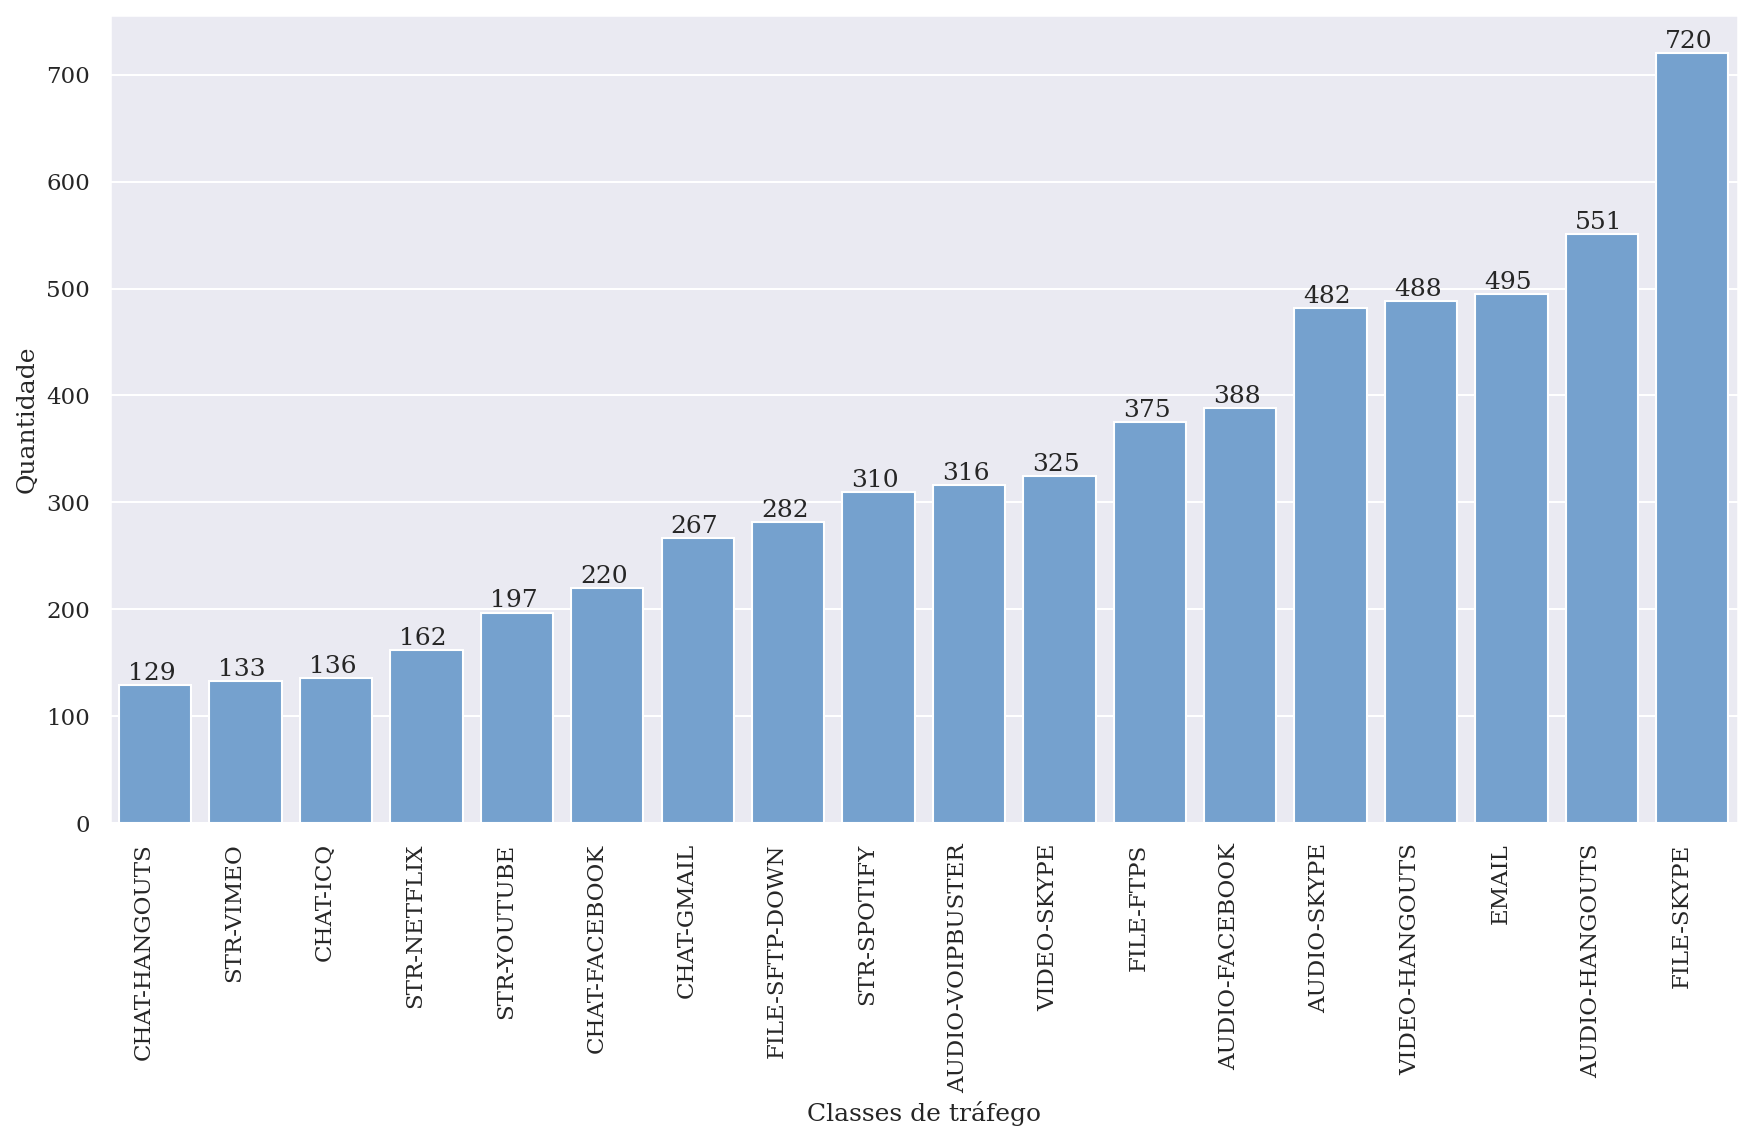

In [15]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
#sns.set_style("darkgrid")
total=(base["category"].shape[0])*1.
#palette_pub_cubehelix = sns.cubehelix_palette(len(classe_label), start=3, rot=0, reverse=True)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})


res=plt.subplots(figsize = (14,7))
res=sns.countplot(x=base["category"], 
                 orient="V",
                  palette=["#66A1DD"],
                 #palette=palette_pub_cubehelix,
                 order=base['category'].value_counts( ).sort_values().index
                )
res.set_xticklabels(res.get_xticklabels(), rotation=90, ha="right")
res.set(xlabel='Classes de tráfego', ylabel='Quantidade')

for p in res.patches:
        res.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))

#for p in res.patches:
#        res.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#ax.yaxis.set_ticks(np.linspace(0, total, 11))     

#res.yaxis.set_ticks(np.linspace(0, total, 11))     


#_ = res.set_yticklabels(map('{:.1f}%'.format, 100*res.yaxis.get_majorticklocs()))
_ = res.set_yticklabels(map('{:.0f}'.format, res.yaxis.get_majorticklocs()))

In [16]:
# transformando dados categoricos em numéricos
encoder = LabelEncoder()
classe = encoder.fit_transform(classe)

In [17]:
# normalizando dados
#scaler =  MinMaxScaler()
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

In [18]:
#  calculo de  neurônios
n_previsores=np.shape(previsores)[1]
n_classes = len(np.unique(classe))
n_hiden=int((np.shape(previsores)[1] + len(np.unique(classe)))/2)

#n_hiden=50


In [19]:
print(n_previsores,n_hiden,n_classes)

40 29 18


In [20]:
model = Cnn1dNeuralNetwork()

In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate,
   # weight_decay = 0.0001
                      )

In [22]:
kf = KFold(n_splits=k, random_state=None)

accuracy_stack = np.array([], dtype=float) 
precision_stack = np.array([], dtype=float) 
recall_stack = np.array([], dtype=float) 
specificity_stack = np.array([], dtype=float) 
f1_score_stack = np.array([], dtype=float) 

matriz_score = []

train_accu=[]
train_loss=[]

test_accu=[]
test_loss=[]

In [23]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device='cpu'
print(device)
model.to(device)

cpu


Cnn1dNeuralNetwork(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Sequential(
    (0): Linear(in_features=320, out_features=230, bias=True)
    (1): BatchNorm1d(230, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (dense2): Sequential(
    (0): Linear(in_features=230, out_features=230, bias=True)
    (1): BatchNorm1d(230, eps=1e-05, moment

In [24]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("darkgrid")

In [25]:
folds=[]
y_score = np.empty((0,n_classes), float)
y_true  = np.array([], dtype=int) 
y_pred  = np.array([], dtype=int) 

for i in range(k):
    folds.append(Fold())

# indexador de fold
j=0

start_time = time.perf_counter()

for train_index , test_index in kf.split(previsores):
    #print('Fold %3d: ' % (j+1))
    previsores_treinamento, previsores_teste = previsores[train_index,:], previsores[test_index,:]
    classe_treinamento, classe_teste = classe[train_index] , classe[test_index]
    
    previsores_treinamento = torch.tensor(previsores_treinamento, dtype=torch.float)
    classe_treinamento = torch.tensor(classe_treinamento, dtype=torch.long)
    
    previsores_teste = torch.tensor(previsores_teste, dtype=torch.float)
    classe_teste = torch.tensor(classe_teste, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
    
    test_dataset = torch.utils.data.TensorDataset(previsores_teste, classe_teste)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
        
    for epoch in range(epochs):
        
        model.train()
        
        running_loss = 0.
        running_accuracy = 0.
      
        for data in train_loader:
            
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            inputs = inputs.unsqueeze(1)

            #print(inputs.shape)
            # zera os gradientes
            optimizer.zero_grad()

            # Valores das previsões
            outputs = model.forward(inputs)
        
            # Calculo do erro
            loss = criterion(outputs, labels)
            
            #loss = loss +  L1(model, 0.0001) + L2(model, 0.0001)

            
            # inicia o processo de backpropagation
            loss.backward()
            
            # recria os valores das previsões passando a função softmax, retonando as probabilidades
            outputs = F.softmax(outputs)
             
            
            
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
            #atualiza os pesos
            optimizer.step()
        
            # acumula o total da época
            running_loss += loss.item()
        
            # outputs = [np.argmax(t) for t in outputs.detach().numpy()]
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            outputs = [np.argmax(t) for t in outputs.detach().cpu().numpy()]

        
        folds[j].train_accuracy.append(running_accuracy/len(train_loader))
        folds[j].train_loss.append(running_loss/len(train_loader))

        
        model.eval()
    
        running_loss = 0.
        running_accuracy = 0.
    
        for data in test_loader:
           
            # cada iteração é um batch, não esquecer disso.
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)

            # optimizer.zero_grad()
    
            outputs = model.forward(inputs)
        
            loss = criterion(outputs, labels)
            #loss = loss +  L1(model, 0.0001) + L2(model, 0.0001)

            # loss.backward()
            # optimizer.step()
            
            outputs = F.softmax(outputs)

            y_score = np.vstack((y_score, outputs.detach().cpu().numpy()))
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            y_true   =  np.concatenate((y_true ,[np.argmax(t) for t in outputs.detach().cpu().numpy()]))
            # Isso desconectará o tensor da GPU, passará para cpu e depois converterá para numpy.
            y_pred  =  np.concatenate((y_pred, labels.detach().cpu().numpy()))
            
           
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
            running_loss += loss.item()
        
        folds[j].test_loss.append(running_loss/len(test_loader))
        
        folds[j].test_accuracy.append(running_accuracy/len(test_loader))
        folds[j].test_precision.append(precision_score( y_true, y_pred,average='macro'))
        folds[j].test_recall.append(recall_score( y_true, y_pred,average='macro'))
        folds[j].test_f1_score.append(f1_score( y_true, y_pred,average='macro'))

    
        #folds[j].confusion_matrix   = confusion_matrix(y_true , y_pred)
        
        color_text = "\33[30m"
        if ((epoch == 0) or (folds[j].test_accuracy[-1] > folds[j].major_accuracy)):
            color_text = "\33[34m"
            folds[j].major_accuracy = folds[j].test_accuracy[-1]
       
        
        #if epoch==0:
        #    print("Na mão {:.5f}".format(running_accuracy/len(test_loader)))
        #    print("Na mão {:.5f}".format(accuracy_score( y_true, y_pred)))
       
    
        #np.append(folds[j].last_true, y_true, axis=0)
        #np.append(folds[j].last_pred, y_true, axis=0)
        
        #print(y_score.shape,y_true.shape,y_pred.shape)
        
        # guarda 
        folds[j].last_score = y_score
        folds[j].last_true = y_true
        folds[j].last_pred= y_pred
        
        
        # zera os armazenadores que servirão para formar a MC do Fold
        y_true  = np.array([], dtype=int) 
        y_pred  = np.array([], dtype=int)
        y_score = np.empty((0,n_classes), float)
        
       
        print('%s(%2d|%3d): %.10f;%.10f;%.10f;%.10f\033[m' % (
        #print('%s(%2d|%3d): %.10f;%.10f;%.10f;%.10f\033[m' % (
            color_text,
            j+1,
            epoch + 1,
            #folds[j].train_loss[-1], 
           # folds[j].train_accuracy[-1],
            #folds[j].test_loss[-1], 
            folds[j].test_accuracy[-1],
            #folds[j].train_loss[-1]/folds[j].test_loss[-1],
            #folds[j].test_accuracy[-1]/folds[j].train_accuracy[-1]
            folds[j].test_precision[-1],
            folds[j].test_recall[-1],
            folds[j].test_f1_score[-1],
        ))
        
        
    # armazena em um vetor a última acurácia de testes de cada fold
    j+=1
    
    #reseta todos os pesos da redes para valores randômicos
    model.apply(weight_reset)
    
end_time = time.perf_counter()

( 1|  1): 0.7282986111;0.6483478787;0.7273305338;0.6331210425
( 1|  2): 0.8602430556;0.8157989450;0.8071420948;0.7949555934
( 1|  3): 0.9357638889;0.9018027583;0.9152037604;0.9031671507
( 1|  4): 0.9418402778;0.9118939208;0.9261844535;0.9152599666
( 1|  5): 0.9470486111;0.9220376504;0.9287637865;0.9228312083
( 1|  6): 0.9487847222;0.9256128481;0.9370486233;0.9255302433
( 1|  7): 0.9539930556;0.9312477100;0.9386554901;0.9325000634
( 1|  8): 0.9522569444;0.9292739376;0.9379134573;0.9301113913
( 1|  9): 0.9539930556;0.9328329499;0.9408754500;0.9338108793
( 1| 10): 0.9609375000;0.9425600135;0.9515325563;0.9436216940
( 1| 11): 0.9626736111;0.9460511096;0.9585427053;0.9484088436
( 1| 12): 0.9635416667;0.9462190551;0.9558358055;0.9493676940
( 1| 13): 0.9600694444;0.9420003743;0.9495147589;0.9431292686
( 1| 14): 0.9618055556;0.9419743753;0.9545129600;0.9455802002
( 1| 15): 0.9618055556;0.9460609156;0.9513422724;0.9470321207
( 1| 16): 0.9618055556;0.9439610071;0.9507788131;0.9456788426
( 1| 17)

( 3| 19): 0.9713541667;0.9589640753;0.9618815908;0.9598707066
( 3| 20): 0.9713541667;0.9594103956;0.9637065737;0.9610676886
( 3| 21): 0.9739583333;0.9596836260;0.9668916271;0.9626388141
( 3| 22): 0.9756944444;0.9621405981;0.9670874663;0.9641513469
( 3| 23): 0.9748263889;0.9615525027;0.9717752121;0.9658600575
( 3| 24): 0.9756944444;0.9628630732;0.9701278333;0.9661160965
( 3| 25): 0.9791666667;0.9694127152;0.9726266672;0.9706075625
( 3| 26): 0.9782986111;0.9671288324;0.9695440321;0.9680669890
( 3| 27): 0.9739583333;0.9633496949;0.9677872025;0.9651227472
( 3| 28): 0.9748263889;0.9609026966;0.9655970507;0.9628822048
( 3| 29): 0.9774305556;0.9671124195;0.9706995334;0.9687306586
( 3| 30): 0.9756944444;0.9660808226;0.9692899810;0.9675395723
( 3| 31): 0.9756944444;0.9656043287;0.9696911912;0.9669973349
( 3| 32): 0.9774305556;0.9656753486;0.9670151869;0.9656079257
( 3| 33): 0.9722222222;0.9608953056;0.9626210943;0.9613356945
( 3| 34): 0.9722222222;0.9615459866;0.9651734258;0.9628760350
( 3| 35)

( 5| 37): 0.9791666667;0.9720340441;0.9680767478;0.9696745227
( 5| 38): 0.9765625000;0.9707230684;0.9657367410;0.9676637736
( 5| 39): 0.9756944444;0.9680767052;0.9613318980;0.9640429007
( 5| 40): 0.9756944444;0.9682770460;0.9646453810;0.9660082531
( 5| 41): 0.9765625000;0.9683492373;0.9639882183;0.9656548245
( 5| 42): 0.9756944444;0.9665438506;0.9660228499;0.9657114821
( 5| 43): 0.9756944444;0.9657863595;0.9652559448;0.9648048676
( 5| 44): 0.9730902778;0.9622770317;0.9575280068;0.9594332845
( 5| 45): 0.9748263889;0.9655241658;0.9630917643;0.9637685907
( 5| 46): 0.9748263889;0.9656616479;0.9626280458;0.9637368195
( 5| 47): 0.9774305556;0.9697474686;0.9667223381;0.9677700376
( 5| 48): 0.9748263889;0.9661582256;0.9653663728;0.9654887798
( 5| 49): 0.9765625000;0.9687018805;0.9635547989;0.9651741874
( 5| 50): 0.9782986111;0.9699129468;0.9684594090;0.9688165201


### Acurácia por Fold

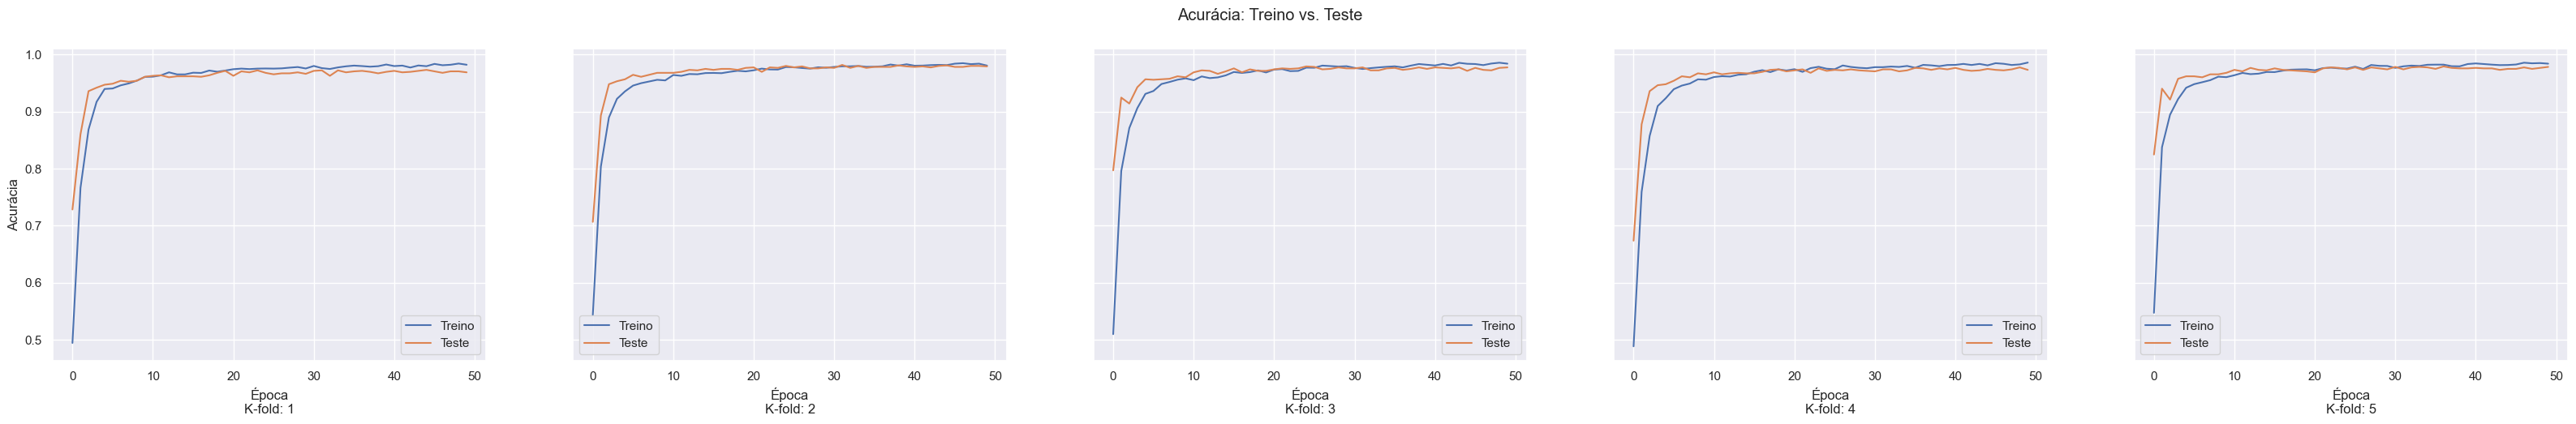

In [26]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Acurácia: Treino vs. Teste')
i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[folds[i].train_accuracy,
            folds[i].test_accuracy],
            markers=False, 
            dashes=False,   
            )
    res.set(xlabel='Época\nK-fold: {:d}'.format(i+1), ylabel='Acurácia')
    res.legend(labels=["Treino","Teste"])   

### Perda por Fold

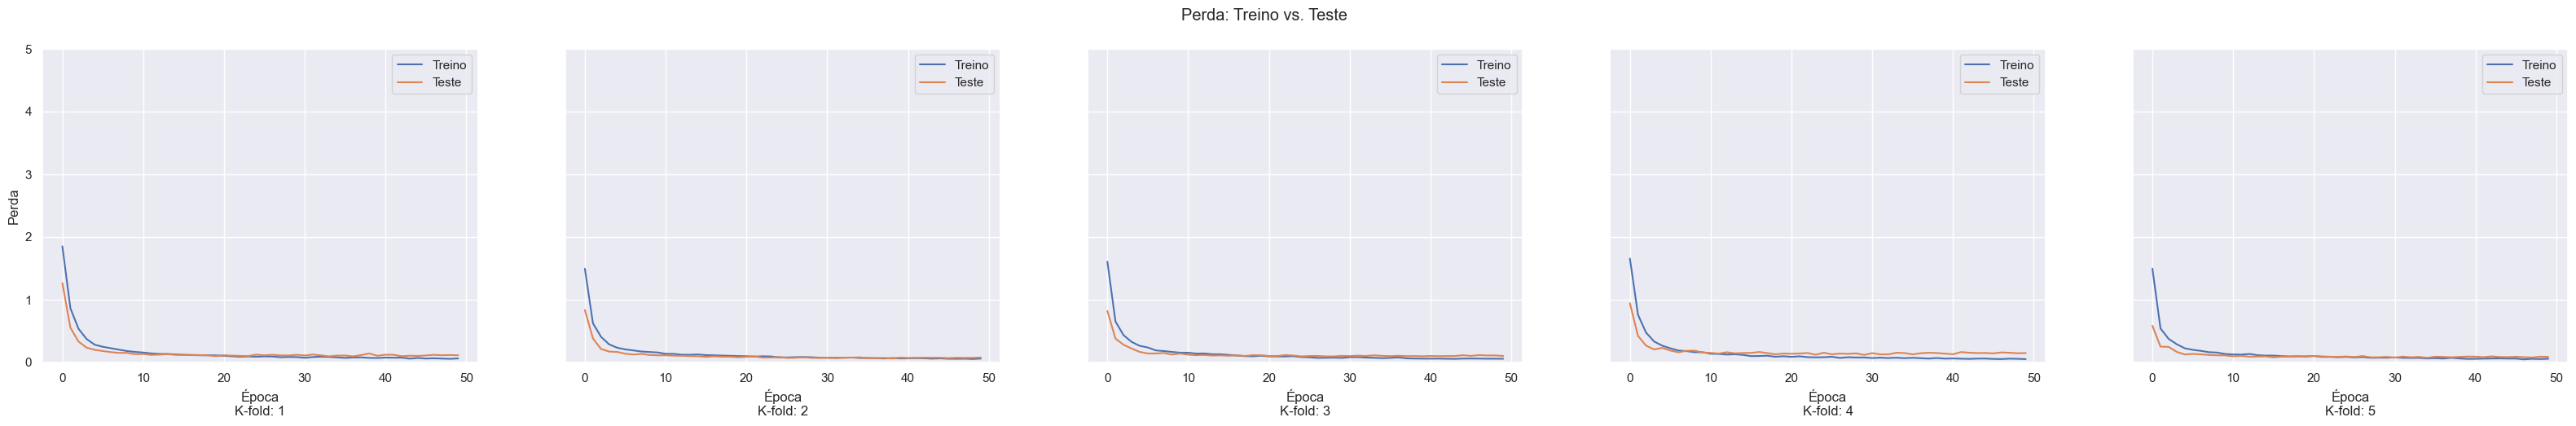

In [27]:
fig, axes = plt.subplots(1, k, figsize=(40,k ), sharey=True, sharex=True)
fig.suptitle('Perda: Treino vs. Teste')
i=0
for i in range(k):
    res= sns.lineplot(
        ax=axes[i],
        data=[
            folds[i].train_loss,
            folds[i].test_loss],
        markers=False, 
        dashes=False    
        )

    res.set(xlabel='Época\nK-fold: {:d}'.format(i+1), ylabel='Perda')
    res.legend(labels=["Treino","Teste"])
    plt.ylim(0, 5)

In [28]:
for i in range(k):
    folds[i].confusion_matrix = confusion_matrix(folds[i].last_true, folds[i].last_pred)
    folds[i].accuracy = accuracy_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),normalize = True)
    folds[i].precision = precision_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].recall = recall_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].f1_score = f1_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    
    accuracy_stack = np.append(accuracy_stack,folds[i].accuracy) 
    precision_stack = np.append(precision_stack,folds[i].precision) 
    recall_stack = np.append(recall_stack,folds[i].recall) 
    f1_score_stack = np.append(f1_score_stack,folds[i].f1_score) 

    

### Matriz de confusão por Fold

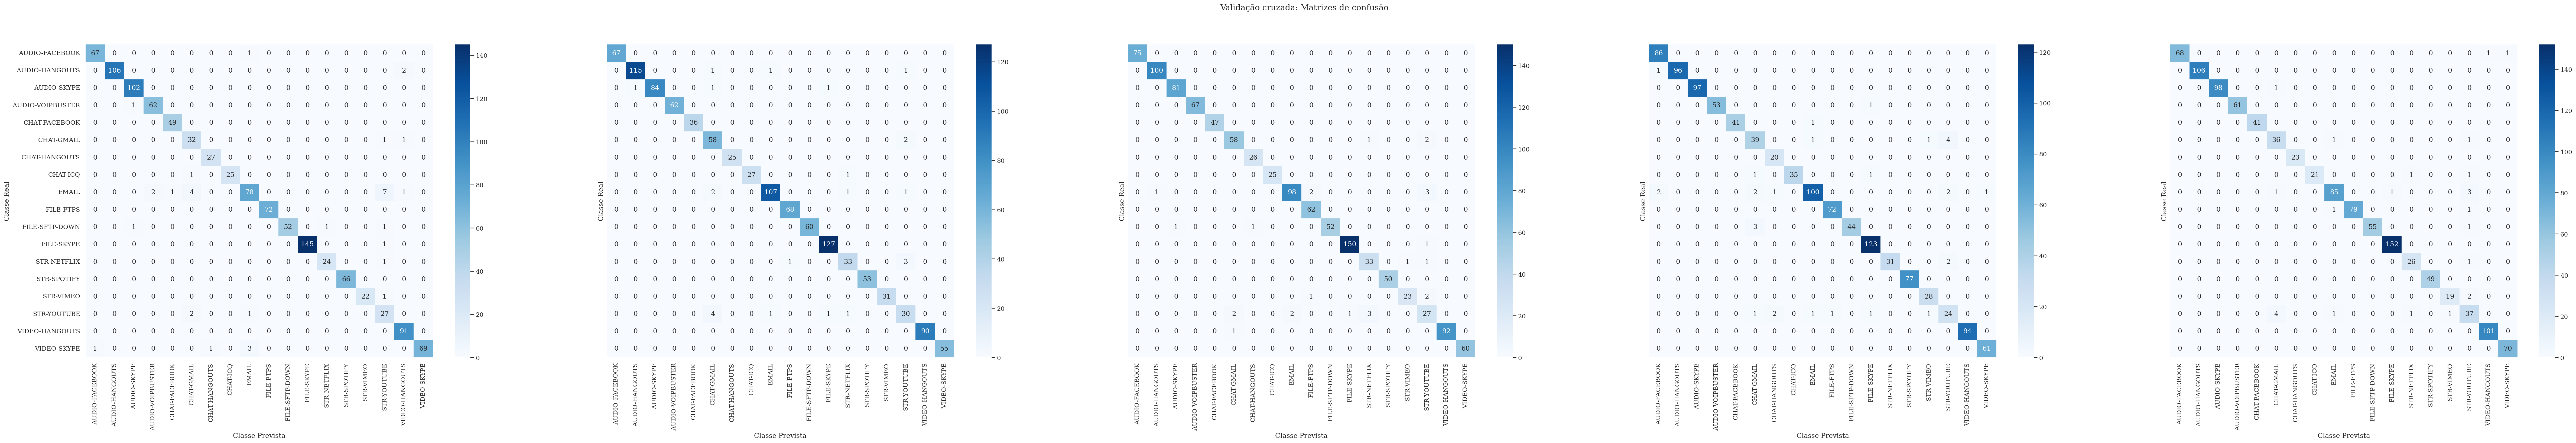

In [29]:
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')

#sns.set_style("darkgrid")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

fig, axes = plt.subplots(1, k, figsize=(80, 10), sharey=True)
fig.suptitle('Validação cruzada: Matrizes de confusão')

for i in range(k):
    res= sns.heatmap(folds[i].confusion_matrix,
                ax=axes[i],
                annot = True,
                linecolor='black',
                xticklabels=classe_label,
                yticklabels=classe_label,
                cmap="Blues" ,
                    fmt='g')
    res.set(xlabel='Classe Prevista',ylabel='Classe Real')
    #res.axhline(y = 0, color = 'k',linewidth = 2) 
    #res.axhline(y = len(classe_label), color = 'k', linewidth = 2) 
    #res.axvline(x = 0, color = 'k', linewidth = 2) 
    #res.axvline(x = len(classe_label), color = 'k', linewidth = 2)

In [30]:
#variancia = accuracy_stack.std() ** 2
print('Tempo de Treino + teste: {0:.10f} sec'.format(end_time - start_time))
#print('Variancia da acurácia: {0:.5f}'.format((variancia)))


print("Fold\tAcc.\tPrec\tRec\tF1-s")
for i in range(k):
#    print("{:d}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}".format(i+1,
    print("{:d}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}".format(i+1,
                                                                     
                                                                     folds[i].accuracy,
                                                                     folds[i].precision,
                                                                     folds[i].recall,
                                                                     #folds[i].specificity,
                                                                     folds[i].f1_score 
                                                                    ))
    

Tempo de Treino + teste: 103.6191670000 sec
Fold	Acc.	Prec	Rec	F1-s
1	0.96875	0.95831	0.96555	0.96057
2	0.97917	0.97496	0.97432	0.97446
3	0.97743	0.96773	0.96876	0.96802
4	0.97309	0.96024	0.96309	0.96110
5	0.97830	0.96991	0.96846	0.96882


In [31]:
matrizes = [] 
total_accuracy = []
total_precision = []
total_recall = []
total_specificity = []
total_f1_score = []


for i in range(k):
    matrizes.append(folds[i].confusion_matrix)
    total_accuracy.append( folds[i].accuracy)
    total_precision.append( folds[i].precision)
    total_recall.append( folds[i].recall)
    total_specificity.append( folds[i].specificity)
    total_f1_score.append( folds[i].f1_score)

In [32]:
matriz_final = np.mean(matrizes, axis=0)


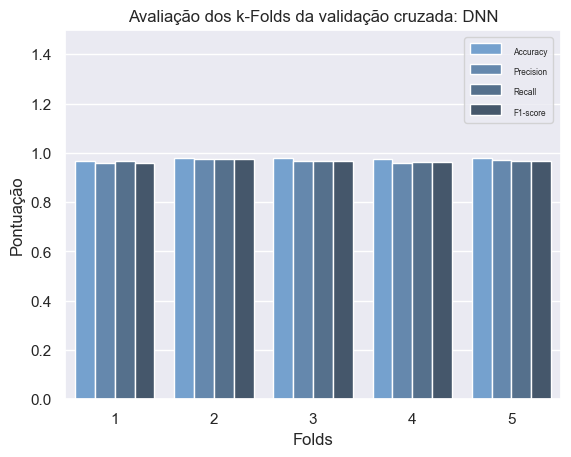

In [33]:
array = [] 
for i in range(k):
    array.append([i+1,folds[i].accuracy,'Accuracy'])
    array.append([i+1,folds[i].precision,'Precision'])
    array.append([i+1,folds[i].recall,'Recall'])
    array.append([i+1,folds[i].f1_score,'F1-score'])
    

column_values = ['fold','valor','metric']
df = pd.DataFrame(data = array,columns = column_values)

sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_palette(sns.dark_palette("#66A1DD", reverse=True, as_cmap=False))


fig = sns.barplot(x='fold', y='valor', hue='metric', data=df)
plt.setp(fig.get_legend().get_texts(), fontsize='6') # for legend text
fig.legend_.set_title(None)

plt.xlabel("Folds")
plt.ylabel("Pontuação")
plt.title("Avaliação dos k-Folds da validação cruzada: DNN") 
plt.ylim(0,1.5)

plt.show(fig)


### Métricas na fase de testes

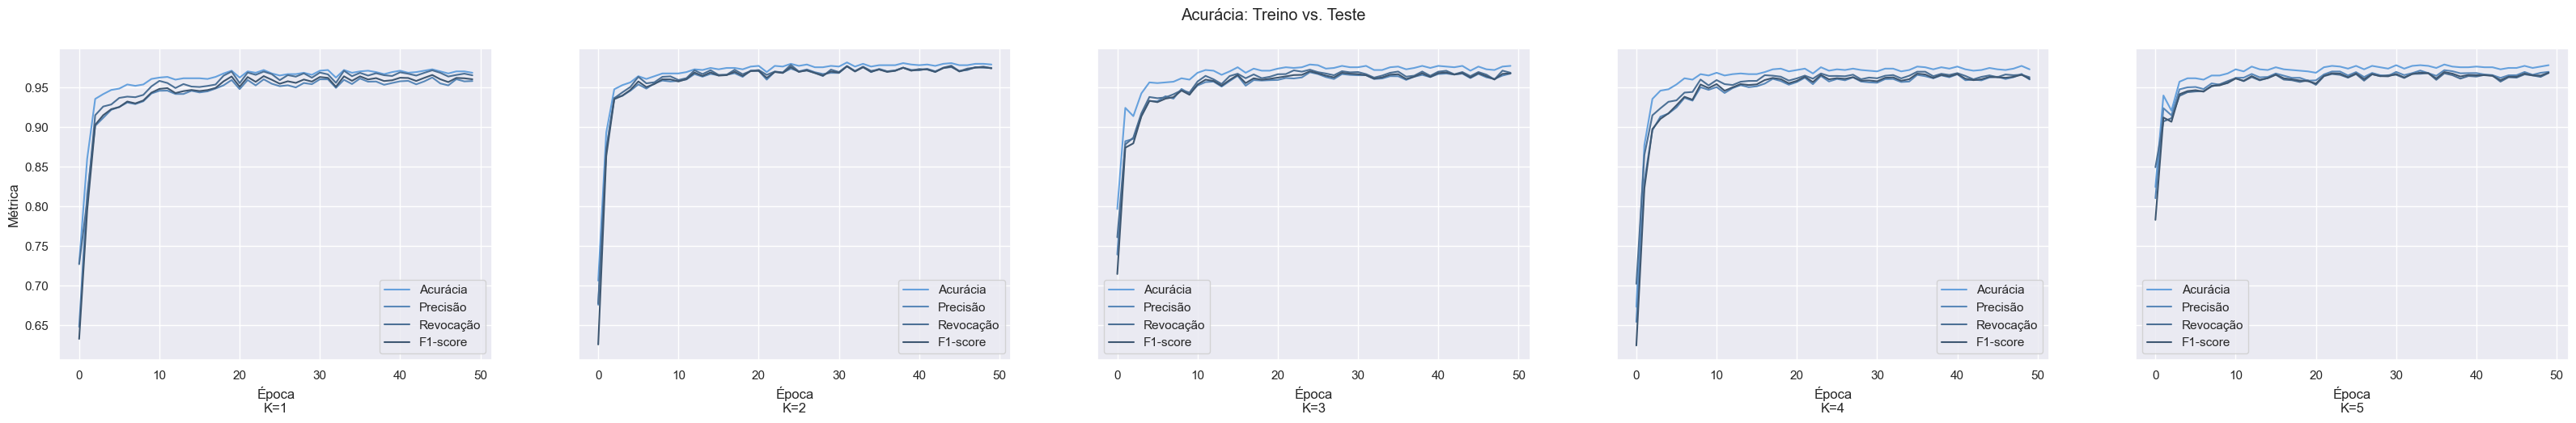

In [34]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Acurácia: Treino vs. Teste')

i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[
                folds[i].test_accuracy,
                folds[i].test_precision,            
                folds[i].test_recall,
                folds[i].test_f1_score,
                #folds[i].test_specificity
            ],
            markers=False, 
            dashes=False,   
            )
    
    res.set(xlabel='Época\nK={:d}'.format(i+1), ylabel='Métrica')
    res.legend(labels=["Acurácia","Precisão","Revocação","F1-score"])  
    #res.legend(labels=["Accuracy","Precision","Recall","Specificity","F1-score"])  

[Text(0.5, 69.24999999999999, 'Classe Prevista'),
 Text(209.25, 0.5, 'Classe Real')]

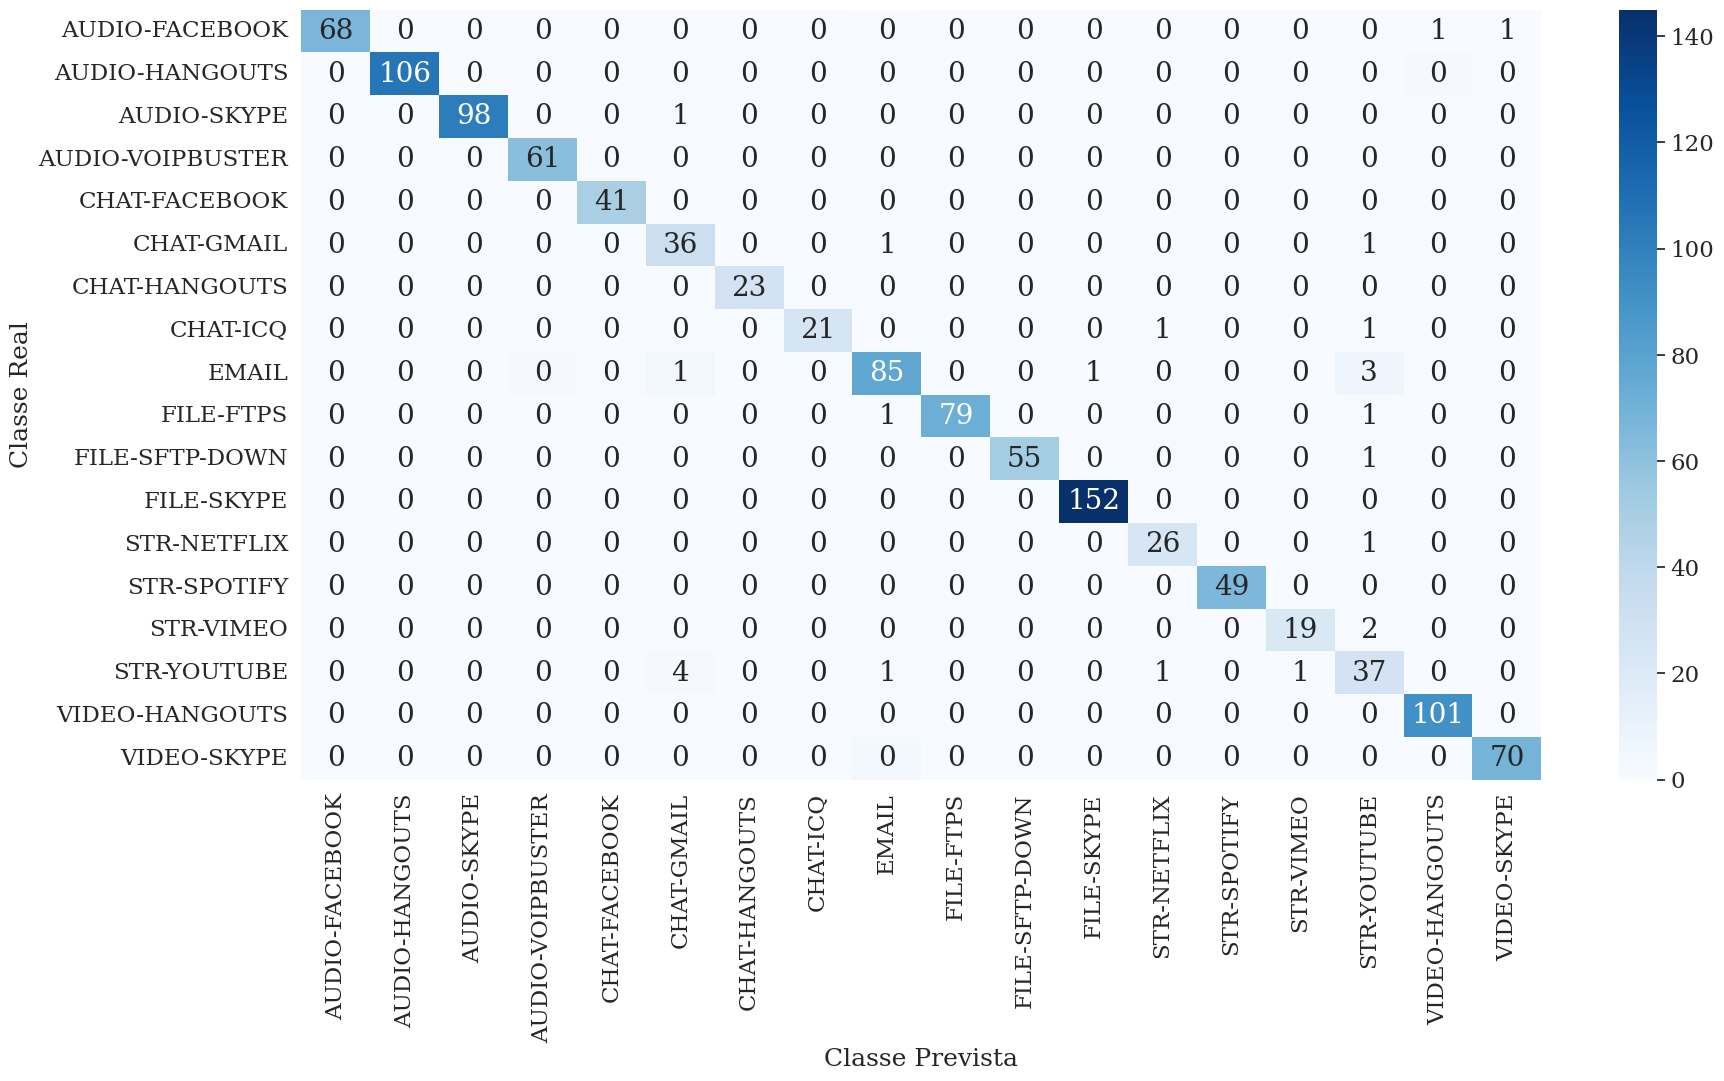

In [35]:
i=4

#----------------------------
plt.figure(figsize=(20, 10))
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(font_scale=1.5)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
res=sns.heatmap(folds[0].confusion_matrix,
                annot=folds[i].confusion_matrix,
                xticklabels=classe_label,
                yticklabels=classe_label,
                cmap="Blues",
                annot_kws={'size': 20},
                fmt='g')

res.set( xlabel="Classe Prevista",
        ylabel="Classe Real")

In [36]:
classe_label

array(['AUDIO-FACEBOOK', 'AUDIO-HANGOUTS', 'AUDIO-SKYPE',
       'AUDIO-VOIPBUSTER', 'CHAT-FACEBOOK', 'CHAT-GMAIL', 'CHAT-HANGOUTS',
       'CHAT-ICQ', 'EMAIL', 'FILE-FTPS', 'FILE-SFTP-DOWN', 'FILE-SKYPE',
       'STR-NETFLIX', 'STR-SPOTIFY', 'STR-VIMEO', 'STR-YOUTUBE',
       'VIDEO-HANGOUTS', 'VIDEO-SKYPE'], dtype=object)

### Matriz de confusão unificada

[ 99.18032787  98.8657845   99.1416309   99.3485342   99.53488372
  93.69747899 100.          95.68345324  92.49011858  99.43661972
  96.69117647  99.71387697  93.63057325 100.          95.34883721
  81.92090395  99.78678038  98.4375    ]
                  precision    recall  f1-score   support

  AUDIO-FACEBOOK       0.99      0.99      0.99       366
  AUDIO-HANGOUTS       1.00      0.99      0.99       529
     AUDIO-SKYPE       0.99      0.99      0.99       466
AUDIO-VOIPBUSTER       0.99      0.99      0.99       307
   CHAT-FACEBOOK       1.00      1.00      1.00       215
      CHAT-GMAIL       0.88      0.94      0.91       238
   CHAT-HANGOUTS       0.96      1.00      0.98       121
        CHAT-ICQ       1.00      0.96      0.98       139
           EMAIL       0.97      0.92      0.95       506
       FILE-FTPS       0.99      0.99      0.99       355
  FILE-SFTP-DOWN       1.00      0.97      0.98       272
      FILE-SKYPE       0.99      1.00      0.99       699
     S

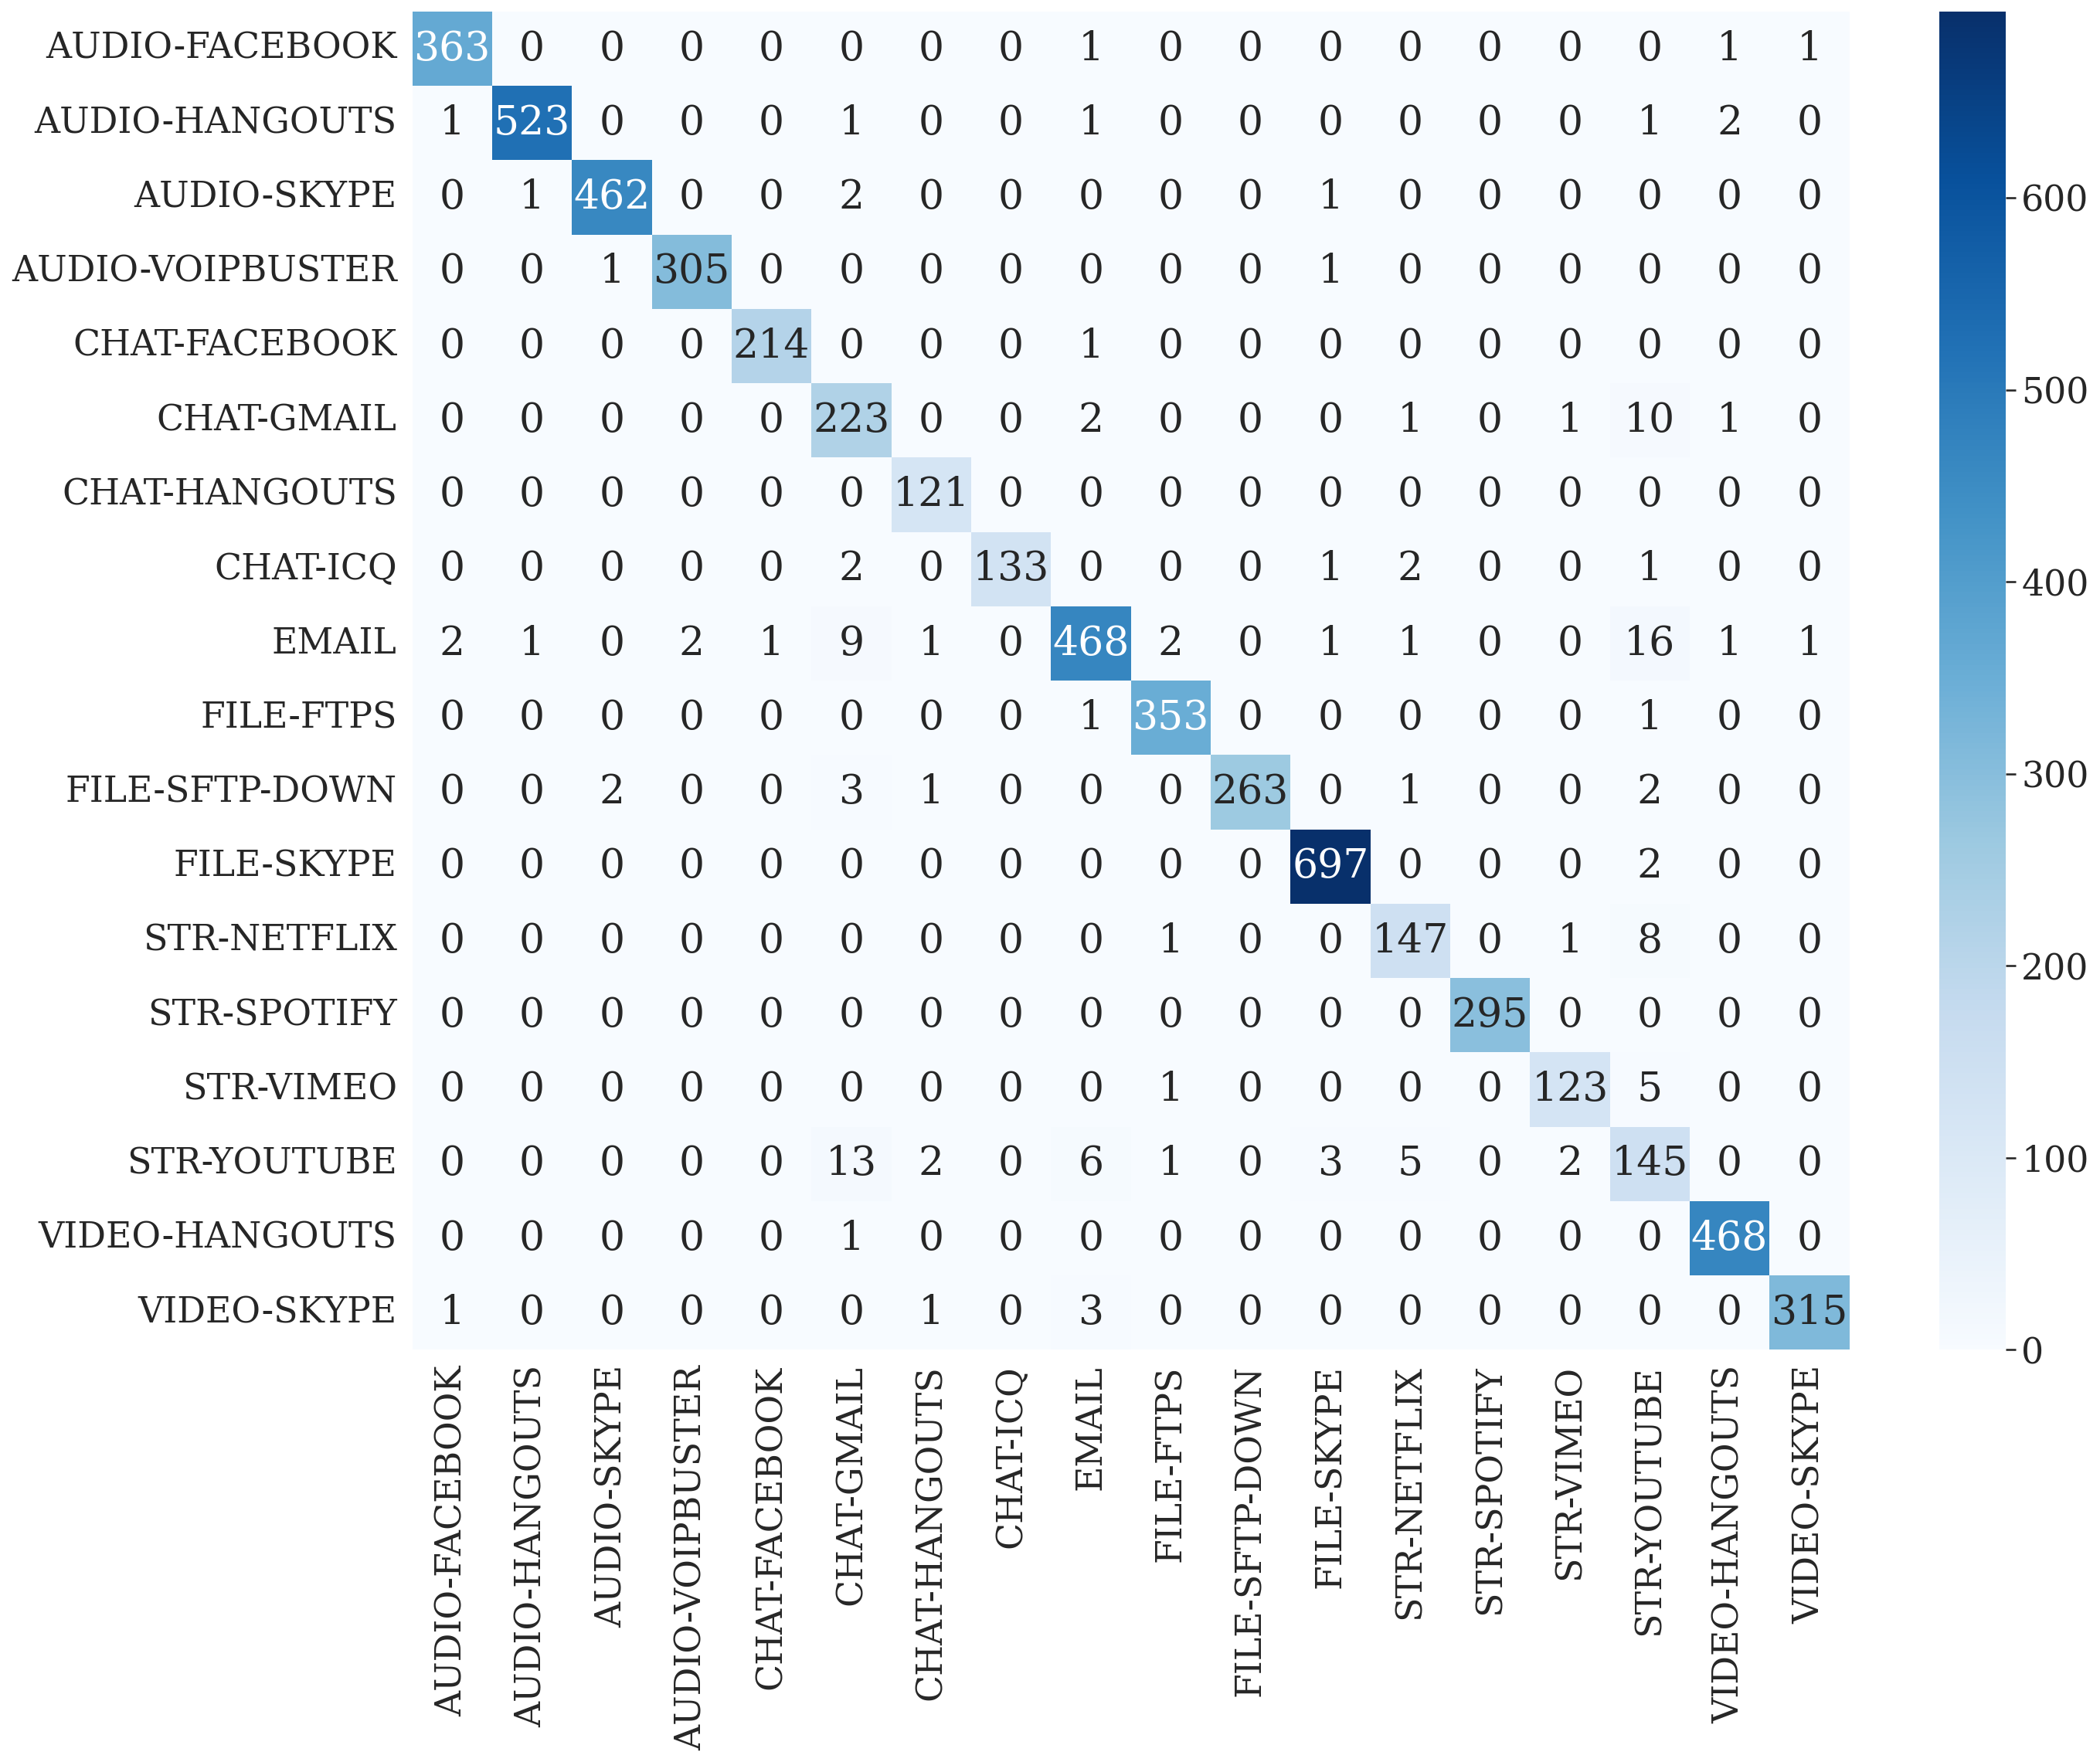

In [37]:
last_true_all = np.array([], dtype=int) 
last_pred_all = np.array([], dtype=int) 
last_score_all = np.empty((0,n_classes), float)


i=0
for i in range(k):
    last_true_all  = np.append(last_true_all,folds[i].last_true)
    last_pred_all  = np.append(last_pred_all,folds[i].last_pred)
    
    last_score_all = np.append(last_score_all,folds[i].last_score,axis=0)

global_confusion_matrix= confusion_matrix(last_true_all,last_pred_all)    


cmat = global_confusion_matrix
print(cmat.diagonal()/cmat.sum(axis=1)*100)
    
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")
sns.set(font_scale=2,rc={"figure.figsize":(1,22)})
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

plt.figure(figsize=(20, 15))
#sns.set(font_scale=2)
#plt.xlabel("Folds")
plt.ylabel("Pontuação")
#plt.title("Fold %i" % i) 
sns.heatmap(global_confusion_matrix,annot=global_confusion_matrix,xticklabels=classe_label,
            yticklabels=classe_label,
            cmap="Blues",
            annot_kws={'size': 25},
            fmt='g')


clf_report=classification_report(last_true_all, last_pred_all, target_names=classe_label)

print(clf_report)


#fig, axes = plt.subplots(1, 1, figsize=(10, 30), sharey=True)
#fig.suptitle('Acurácia: Treino vs. Teste')


#clf_report =classification_report(last_true_all, last_pred_all, target_names=classe_label,output_dict=True)
 
#res= sns.heatmap(annot = True,
#                data= pd.DataFrame(clf_report).iloc[:-1, :].T,
#                 cmap="Blues",
#            annot_kws={'size': 30},
#            fmt=".2%") 
#res.set(xlabel='Época\nK={:d}'.format(i+1), ylabel='Métrica')
#res.legend(labels=["Accuracy","Precision","Recall","F1-score"]) 

### Etapa 1: Curva ROC

In [38]:
i=0
j=0
n_samples= last_true_all.shape[0]
x = torch.Tensor(last_true_all)


# Create list n_samples random labels (can also be numpy array)
labels = [random.randrange(n_classes) for _ in range(n_samples)]
# Convert to torch Tensor 
labels_tensor = torch.as_tensor(labels)
# Create one-hot encodings of labels 
y_one_hot = torch.nn.functional.one_hot(x.to(torch.int64),  num_classes=n_classes)
#print(y_one_hot)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i],last_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    #print(roc_auc[i],fpr[i], tpr[i])
    #print('\n')
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), last_score_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

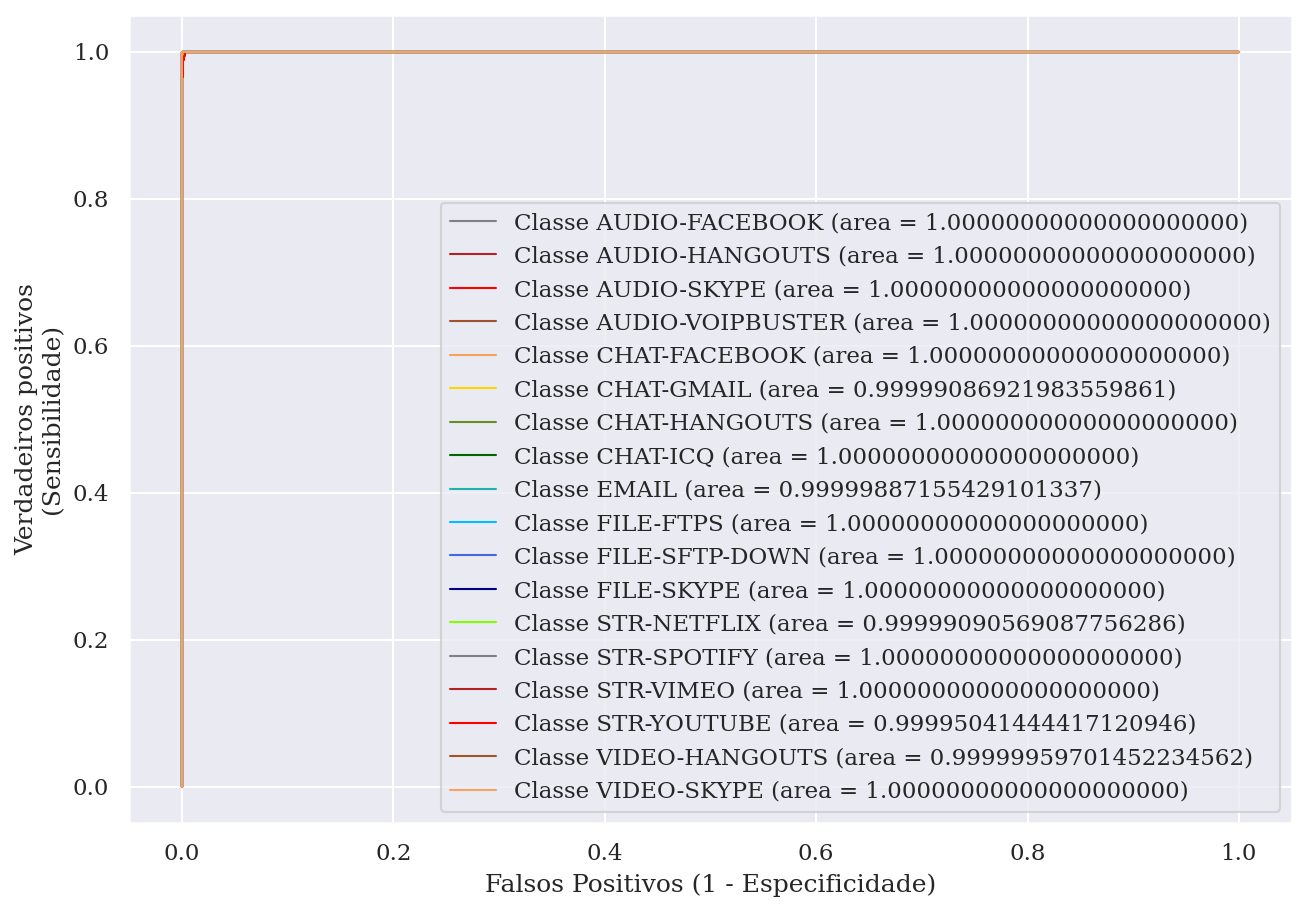

In [39]:
lw = 1 # line_width

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,7))
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['gray','firebrick','red','sienna','sandybrown', 'gold',
                'olivedrab','darkgreen','lightseagreen','deepskyblue','royalblue','navy',
                'chartreuse'
               ])
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(6, 4)})
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='Classe {0} (area = {1:0.20f})'
             ''.format(classe_label[i], roc_auc[i]))
    
plt.xlabel('Falsos Positivos (1 - Especificidade)')
plt.ylabel('Verdadeiros positivos\n(Sensibilidade)')
#plt.title('Curva ROC Multiclasse')
plt.legend(loc="lower right")
plt.show()

In [40]:
folds[0].confusion_matrix

array([[ 67,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0, 106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   2,   0],
       [  0,   0, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   1,  62,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  49,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  32,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   1,   0],
       [  0,   0,   0,   0,   0,   0,  27,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,  25,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   2,   1,   4,   0,   0,  78,   0,   0,   0,   0,
          0,   0,   7,   1,   0],
       [  0,   0,   0,   0,   0,   0,

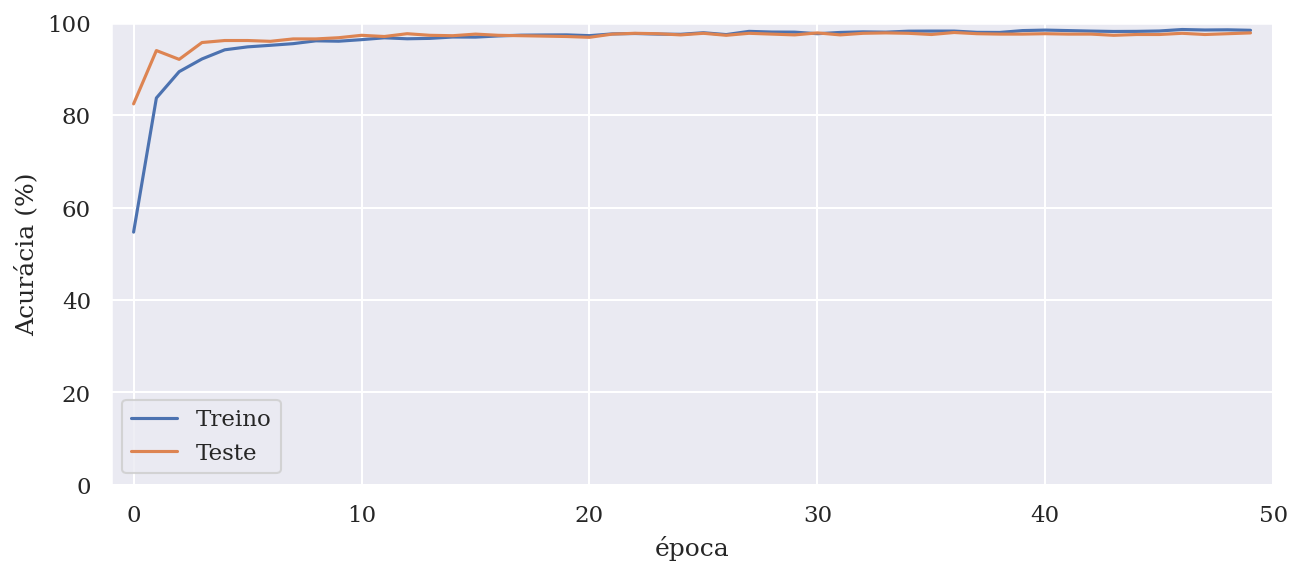

In [41]:
i=4
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_style("darkgrid",{'font.family':'serif', 'font.serif':['Times New Roman']})


plt.figure(figsize=(10,4))
plt.ylim(0, 1)
plt.xlim(-1, epochs)

res= sns.lineplot(
        data=[folds[i].train_accuracy,
            folds[i].test_accuracy ],
        markers=False, 
        dashes=False,   
        )
res.legend(labels=["Treino","Teste"]) 
res.set(xlabel='época', ylabel='Acurácia (%)'.format("0.2f"))
_ = res.set_yticklabels(map('{:.0f}'.format, 100*res.yaxis.get_majorticklocs()))    




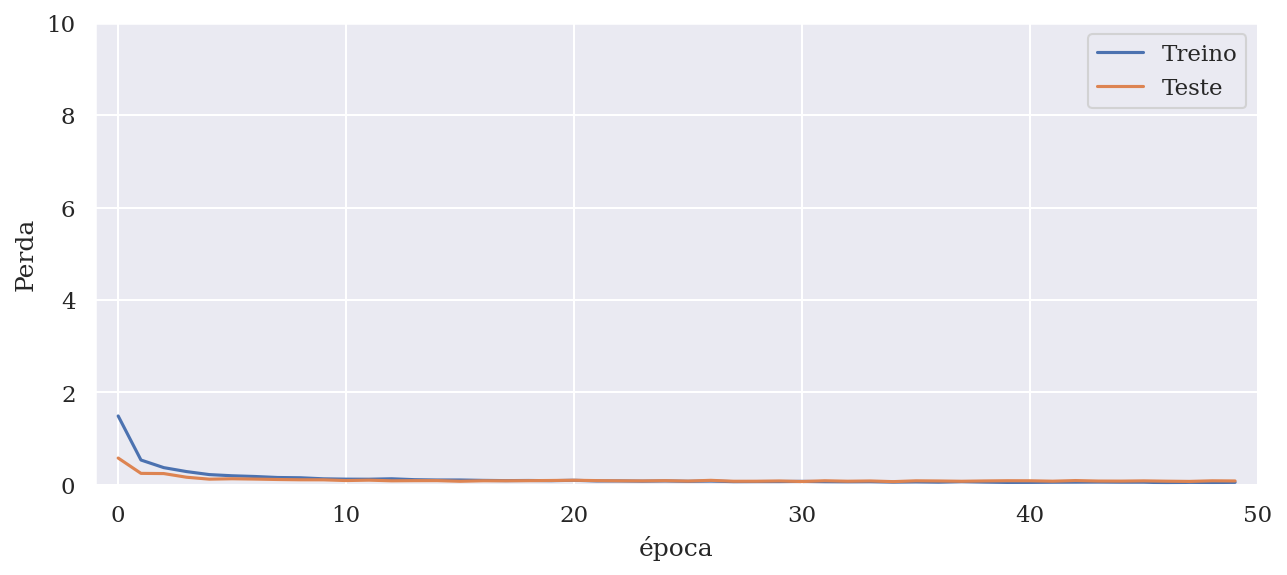

In [42]:
i=4

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_style("darkgrid",{'font.family':'serif', 'font.serif':['Times New Roman']})

plt.figure(figsize=(10,4))
plt.ylim(0, 10)
plt.xlim(-1, epochs)



res= sns.lineplot(
    data=[
        folds[i].train_loss,
        folds[i].test_loss],
    markers=False, 
    dashes=False,
    )

res.set(xlabel='época', ylabel='Perda')
res.legend(labels=["Treino","Teste"])

In [43]:
print("{:0.10f};{:0.10f};{:0.10f};{:0.10f}".format(np.mean(total_accuracy),np.mean(total_precision),np.mean(total_recall),np.mean(total_f1_score)))


0.9753472222;0.9662299396;0.9680349295;0.9665945398


(0.0, 1.0)

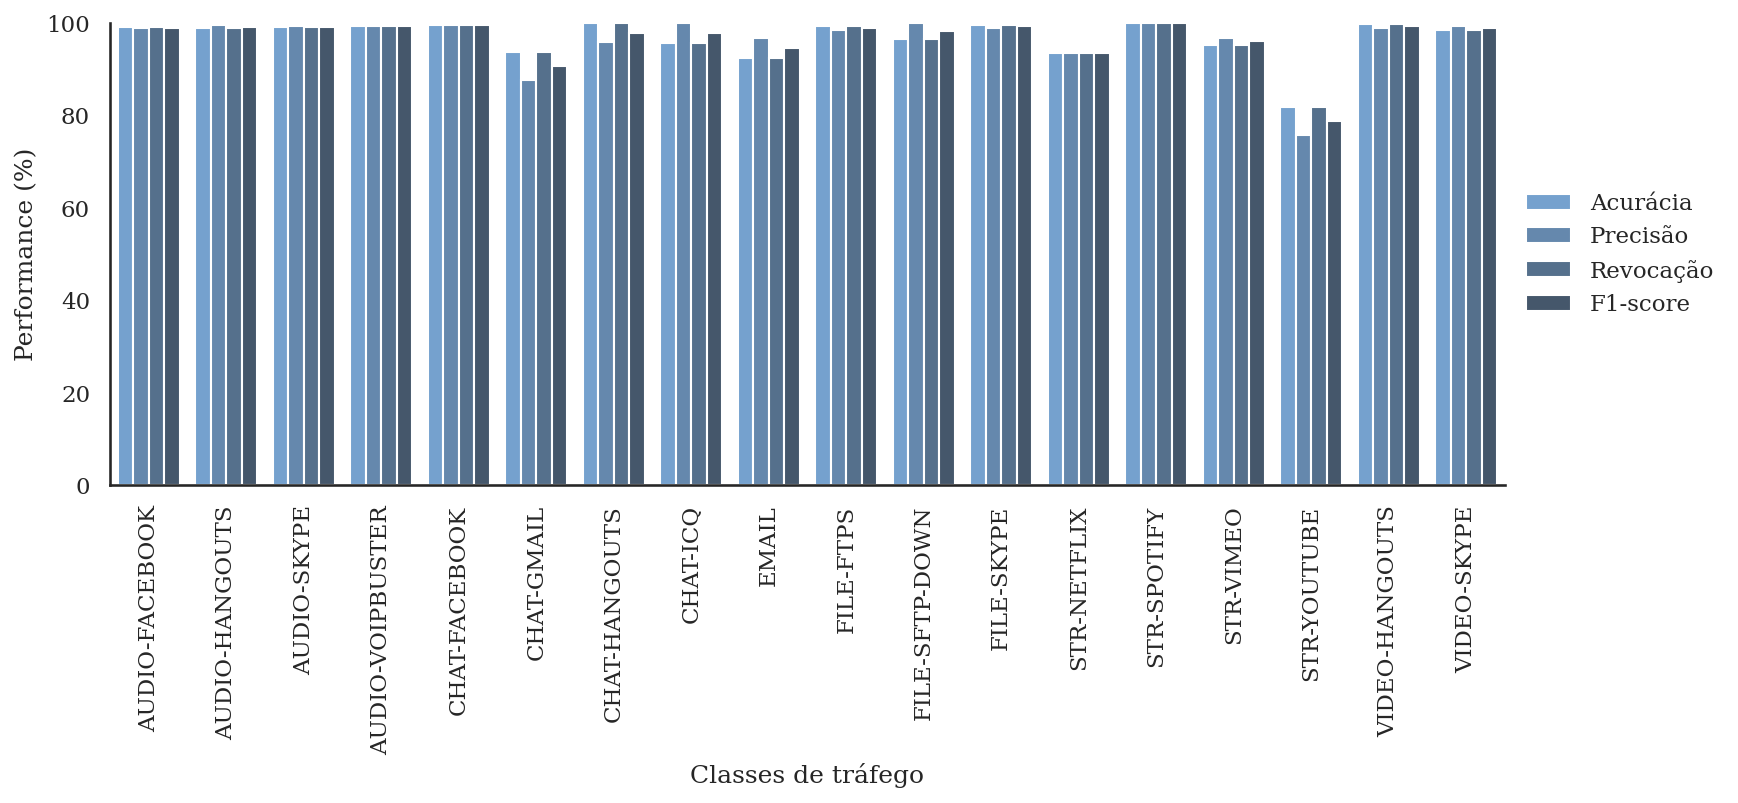

In [44]:
clf_report =classification_report(last_true_all, last_pred_all, target_names=classe_label,output_dict=True)
accuracy_total=global_confusion_matrix.diagonal()/global_confusion_matrix.sum(axis=1)
temp_array = [] 
i=0
for x in classe_label:
    temp_array.append([x,accuracy_total[i],'Acurácia'])
    temp_array.append([x,clf_report[x]['precision'],'Precisão'])
    temp_array.append([x,clf_report[x]['recall'],'Revocação'])
    temp_array.append([x,clf_report[x]['f1-score'],'F1-score'])
    i+=1

column_values = ['class','valor','metric']
df = pd.DataFrame(data = temp_array,columns = column_values)

plt.figure(figsize=(12, 4))

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_palette(sns.dark_palette("#66A1DD", reverse=True, as_cmap=False))
sns.set_style("white")

#("paper")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
res = sns.barplot(x='class', y='valor', hue='metric', data=df)
res.set_xticklabels(res.get_xticklabels(),rotation=90)
res.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)    

_ = res.set_yticklabels(map('{:.0f}'.format, 100*res.yaxis.get_majorticklocs()))    

res.spines.right.set_visible(False)
res.spines.top.set_visible(False)

res.legend_.set_title(None)

plt.xlabel("Classes de tráfego")
plt.ylabel("Performance (%)")
plt.ylim(0,1)



In [45]:
accuracy_stack

array([0.96875   , 0.97916667, 0.97743056, 0.97309028, 0.97829861])

In [46]:
accuracy_stack.mean()

0.9753472222222221

In [47]:
folds[4].confusion_matrix

array([[ 68,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   1],
       [  0, 106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,  98,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,  61,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  41,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  36,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,  23,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  21,   0,   0,   0,   0,   1,
          0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,  85,   0,   0,   1,   0,
          0,   0,   3,   0,   0],
       [  0,   0,   0,   0,   0,   0,